# Sketching AutoEncoder

This is a prototype "sketching" AutoEncoder. The encoder maps an input raster image into an $n\times4$ vector. The decoder is an attempt at creating a differentiable line rasteriser which interprets the encoder output as $n$ vectors of $[x0,y0,x1,y1]$ representing the starting and ending coordinates of a line segment. The decoder doesn't have any learnable parameters and is entirely deterministic.

Rasterisation is normally a non-differentiable process, so we have to use a relaxation that is differentiable, but which also allows significant gradient flow to ensure that the line coordinates are able to be optimised. To do this we create a rasterisation for a line segment based on the Squared Euclidean Distance Transform (which is an image in which each pixel's value is the closest squared Euclidean distance to the line segment).

The Squared EDT is used by a module that rasterises the line segment into an image. The rasterisation function can take a number of forms; in traditional rasterisation this need not be differentiable (we could binary threshold the squared distance map at 0.25 to compute the nearest-neighbour rasterisation), or for example we could just exponentiate the negative squared distance. The "scale", sigma, controls how far away from the segment the gradient will flow (and also how wide the rasterised line will be).

To rasterise multiple lines we've taken a simple 'softor' approach of computing an aggregation of each line segment image, $I_i$ by $1 - \prod_i^n (1 - I_i)$. Effectively if a pixel is 'on' in any of the individual images then this will select it as being 'on' in the output.

Using these ideas we can define a simple AutoEncoder. The encoder is a dense layer (to 64 dims -- arbitrary; first thing tried!) with relu followed by dense (to nlines*4 dims) with tanh (because we'll choose to work in a -1..1 image coordinate space). The decoder is simply a multi-line rasteriser (with no learnable params!).

In [1]:
import torch
import torch.nn as nn
from dsketch.raster.disttrans import line_edt2
from dsketch.raster.raster import exp
from dsketch.raster.composite import softor

class AE(nn.Module):
  def __init__(self, nlines=5, hidden=64, sz=28):
    super(AE, self).__init__()

    # build the coordinate grid:
    r = torch.linspace(-1, 1, sz)
    c = torch.linspace(-1, 1, sz)
    grid = torch.meshgrid(r, c)
    grid = torch.stack(grid, dim=2)
    self.register_buffer("grid", grid)

    # encoder
    self.enc = nn.Sequential(
        nn.Linear(sz**2, hidden),
        nn.ReLU(),
        nn.Linear(hidden, nlines*4),
        nn.Tanh())

  def forward(self, inp, sigma=1e-4):
    # the encoding process will flatten the input and
    # push it through the encoder network
    bs = inp.shape[0]
    x = inp.view(bs, -1) # [batch,28,28] -> [batch,28*28]
    z = self.enc(x) # -> [batch,5*4]
    z = z.view(bs, -1, 2, 2) # -> [batch, 5, 2, 2]

    # Rasterisation steps
    rasters = exp(line_edt2(z, self.grid), sigma) # -> [batch, 5, 28, 28]

    return softor(rasters)

We'll do a simple test on MNIST and try and train the AE to be able to reconstruct digit images (and of course at the same time perform image vectorisation/autotracing). Hyperparameters are pretty arbitrary (defaults for Adam; 256 batch size), although we do anneal the rasteriser scale each epoch (to a point) to initially allow better gradient flow from further away.

In [2]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
import torchvision

batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(28, 28))
    ])
trainset = torchvision.datasets.MNIST('.', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.MNIST('.', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

sigma=1e-1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AE().to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
  for images, classes in trainloader:
    images = images.to(device)
    opt.zero_grad()
    out = model(images, sigma)
    loss = nn.functional.mse_loss(out, images)
    loss.backward()
    opt.step()

  if sigma > 1e-2:
    sigma *= 0.5

  print(loss, sigma)

tensor(0.0896, device='cuda:0', grad_fn=<MseLossBackward>) 0.05
tensor(0.0522, device='cuda:0', grad_fn=<MseLossBackward>) 0.025
tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward>) 0.0125
tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0337, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625


Finally here's a visualisation of a set of test inputs and their rendered reconstructions:

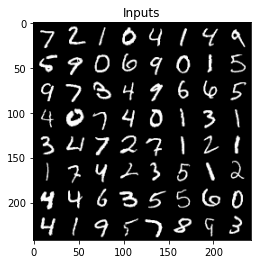

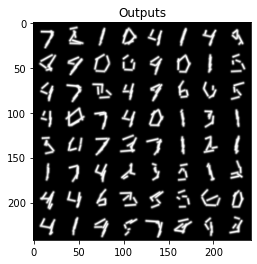

In [3]:
batch = iter(testloader).next()[0][0:64]
out = model(batch.to(device), sigma=1e-2)

plt.figure()
inputs = torchvision.utils.make_grid(batch.unsqueeze(1))
plt.title("Inputs")
plt.imshow(inputs.permute(1,2,0))

plt.figure()
outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
plt.title("Outputs")
plt.imshow(outputs.permute(1,2,0))

# model.rasteriser.rasteriser.mode = 'nn'
# out = model(batch.cuda())
# plt.figure()
# outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
# plt.title("Outputs - hard")
# plt.imshow(outputs.permute(1,2,0))